In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

翻译：将德语翻译成英语

In [51]:
n_step = 5
n_hidden = 128

sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
# S 代表 input的解码开始的标志
# E 代表 output的解码开始的标志
# 错开一位表示，output的解码用到了output的前一位的内容

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w:i for i,w in enumerate(word_list)}
number_dict = {i:w for i,w in enumerate(word_list)}
n_class = len(word_dict)

In [52]:
def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
input_batch, output_batch, target_batch = make_batch()
# input_batch (1,5,11)
# output_batch (1,5,11)
# target_batch (1,5)

In [53]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        # enc_inputs (1,5,11) -> (5,1,11) 
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]
        # dec_inputs (1,5,11) -> (5,1,11)
        # hidden (1,1,128)

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F  (5,1,128)
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)
        # 编码过程

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]  (1,1,128)
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)  
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))  # (1,1,128) 
            # context的维度解释： 这里的第一个1指的是batch_size，第二个1指得是 上下文的step的注意力结果
            
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            # dec_output (1,128) context (1,128)
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))  # (1,256) -> (1, 11)

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn  # (5,11), (5,5)
    
    
    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        # dec_output (1,1,128)   这里是指 输出序列的前一位经过rnn的隐藏层结果
        # enc_outputs (5,1,128)  这里是指 输入序列经过rnn的隐藏层结果
        n_step = len(enc_outputs)  # 5
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)  #  (1,1,5)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [54]:
hidden = torch.zeros(1, 1, n_hidden)

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


D:\software\anaconda\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [55]:
for epoch in range(2000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000482
Epoch: 0800 cost = 0.000154
Epoch: 1200 cost = 0.000075
Epoch: 1600 cost = 0.000044
Epoch: 2000 cost = 0.000028


In [56]:
# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SSSSS']]]
test_batch = torch.FloatTensor(test_batch)
predict, trained_attn = model(input_batch, hidden, test_batch)
print(predict)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

tensor([[12.5311, -2.8637, -2.7157, -2.6841,  1.2780, -2.8028,  0.9134, -0.1137,
         -2.4337, -1.0854, -2.2895],
        [ 1.5402, -3.1265, -3.5508, -4.3131, 12.6553, -3.5405,  1.2448,  0.4846,
         -3.4005,  0.0499, -2.9443],
        [ 1.5803, -3.6186, -4.2921, -3.5869,  1.5879, -3.7818, 12.9197,  0.8593,
         -2.9404, -1.2776, -3.4864],
        [-1.1015, -3.0317, -2.9598, -2.8530, -0.5667, -2.9552, -1.4771, -0.4128,
         -2.7779, 10.9956, -2.7380],
        [ 0.9079, -3.0049, -2.7077, -2.6040,  0.5338, -2.9172,  0.7914, 12.7296,
         -2.7146,  0.8651, -2.4170]], grad_fn=<SqueezeBackward1>)
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


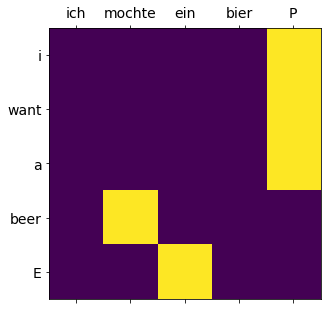

In [57]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()